In [28]:
from tqdm import tqdm
from openprompt.data_utils import PROCESSORS
import torch
from openprompt.data_utils.utils import InputExample
import argparse
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from openprompt import PromptDataLoader
from openprompt.prompts import ManualVerbalizer, ManualTemplate, MixedTemplate, SoftVerbalizer

from openprompt.prompts import SoftTemplate
from openprompt import PromptForClassification

from openprompt.plms.seq2seq import T5TokenizerWrapper, T5LMTokenizerWrapper
from transformers import T5Config, T5Tokenizer, T5ForConditionalGeneration
from openprompt.data_utils.data_sampler import FewShotSampler
from openprompt.plms import load_plm

from utils import Mimic_ICD9_Processor, Mimic_ICD9_Triage_Processor
import time
import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from loguru import logger
import json
import itertools
import torchmetrics.functional.classification as metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

## Notebook for loading trained prompt models
 
This is really just for playing around and testing - will be refined and implemented as a python script 

In [26]:
# create confusion matrix function
def plot_confusion_matrix(cm, class_names, save_dir = None):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes

    credit: https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12
    """

    
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Times New Roman')
    font.set_style('normal')

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     figure.savefig(f'{save_dir}/test_mtx.png')
    
    return figure

In [25]:


def plotConfusionMatrix(cm, classes, annot = False):

    cf_matrix = cm
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(16, 10))
    
    return sn.heatmap(df_cm, annot=False).get_figure()

In [31]:
from sklearn.metrics import classification_report
def evaluate(prompt_model, dataloader, class_labels, mode = "test", use_cuda = True):
    prompt_model.eval()

    allpreds = []
    alllabels = []
    with torch.no_grad():
        for step, inputs in tqdm(enumerate(dataloader), desc = "evaluating"):
            if use_cuda:
                inputs = inputs.cuda()
            logits = prompt_model(inputs)
            labels = inputs['label']
            alllabels.extend(labels.cpu().tolist())
            allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())

    acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
    print(f"accuracy using manual method: {acc}")

    
    print(f"number unique preds: {len(np.unique(allpreds))}")
    print(f"number unique labels: {len(np.unique(alllabels))}")

    
    # get sklearn based metrics
    f1 = f1_score(alllabels, allpreds, average = 'weighted')
    prec = precision_score(alllabels, allpreds, average = 'weighted')
    recall = recall_score(alllabels, allpreds, average = 'weighted')   
    
    # get confusion matric
#     cm = metrics.confusion_matrix(preds = allpreds,target=alllabels, num_classes =50)
    cm = confusion_matrix(alllabels, allpreds)    
    
    
    # classification report
    print(classification_report(alllabels, allpreds, target_names=class_labels))
    
#     cm_figure = plotConfusionMatrix(cm, class_labels)
    cm_figure = plot_confusion_matrix(cm, class_labels)
    
    return acc, prec, recall, f1, cm, cm_figure

the models produced by newest version of experiment_runner.py will save all parameters and ckpt in same place for easy loading. 

In [12]:
# test with new params format
import argparse
ckpt_dir = "./checkpoints/icd9_triage/frozen_plm/emilyalsentzer/Bio_ClinicalBERT_tempmixed0_verbsoft0/version_08-02-2022--15-11/checkpoint.ckpt"
params_dir = "./params/icd9_triage/frozen_plm/emilyalsentzer/Bio_ClinicalBERT_tempmixed0_verbsoft0/version_08-02-2022--15-11/commandline_args.txt"


# works for python ide
# parser = argparse.ArgumentParser()
# args = parser.parse_args()
# with open(f'{params_dir}', 'r') as f:
#     args.__dict__ = json.load(f)


# for notebook use following

with open(f"{params_dir}") as f:
    params = json.load(f)
    
plm_type = params["model"]
plm_name = params["model_name_or_path"]
template_type = params["template_type"]
template_id = params["template_id"]
verbalizer_type = params["verbalizer_type"]
verbalizer_id = params["verbalizer_id"]
data_dir = params["data_dir"]
dataset = params["dataset"]
scripts_path = params["scripts_path"]
init_from_vocab = params["init_from_vocab"]


In [15]:
# example of loading the model from checkpoint
loaded_model = torch.load(ckpt_dir)

In [47]:

loaded_model['template']["soft_embedding.weight"].shape

torch.Size([4, 768])

In [11]:
params

{'shot': -1,
 'seed': 144,
 'plm_eval_mode': False,
 'tune_plm': False,
 'zero_shot': True,
 'model': 'bert',
 'model_name_or_path': 'emilyalsentzer/Bio_ClinicalBERT',
 'project_root': './',
 'template_id': 0,
 'verbalizer_id': 0,
 'template_type': 'mixed',
 'verbalizer_type': 'soft',
 'data_dir': '../data/intermediary-data/',
 'dataset': 'icd9_triage',
 'result_file': './mimic_icd9_top50/st_results/results.txt',
 'scripts_path': './scripts/',
 'class_labels_file': './scripts/mimic_icd9_top50/labels.txt',
 'max_steps': 20000,
 'prompt_lr': 0.3,
 'warmup_step_prompt': 100,
 'num_epochs': 15,
 'batch_size': 4,
 'init_from_vocab': False,
 'eval_every_steps': 100,
 'soft_token_num': 20,
 'optimizer': 'Adafactor'}

In [51]:
def load_trained_prompt_model(ckpt_dir, params_dir,
                              use_cuda = True):
    
    '''
    Function to reload an already trained promptmodelclassifier. At moment this still requires data/task specific 
    manual template or verbalizers to be setup as they need to point to correct scripts.
    
    Args:
        ckpt_dir: path to save promptmodel
        params_dir: path to parameters of training - in newest pipeline will be same as checkpoints dir
        
    '''
    
    # load in saved paramters for the trained model
    with open(f"{params_dir}") as f:
        params = json.load(f)
    # set up the parameters based on the training config
    plm_type = params["model"]
    plm_name = params["model_name_or_path"]
    template_type = params["template_type"]
    template_id = params["template_id"]
    verbalizer_type = params["verbalizer_type"]
    verbalizer_id = params["verbalizer_id"]
    data_dir = params["data_dir"]
    dataset_name = params["dataset"]
    scripts_path = params["scripts_path"]
    init_from_vocab = params["init_from_vocab"]
    batch_size = params["batch_size"]
    tune_plm = params["tune_plm"]
    # set up datasets first    


    dataset = {}
    if dataset_name == "icd9_50":

        logger.warning(f"Using the following dataset: {dataset_name} ")
        Processor = Mimic_ICD9_Processor
        # update data_dir
        data_dir = f"{data_dir}/top_50_icd9"

        # get different splits
        dataset['train'] = Processor().get_examples(data_dir = data_dir, mode = "train")
        dataset['validation'] = Processor().get_examples(data_dir = data_dir, mode = "valid")
        dataset['test'] = Processor().get_examples(data_dir = data_dir, mode = "test")[:500]
        # the below class labels should align with the label encoder fitted to training data
        # you will need to generate this class label text file first using the mimic processor with generate_class_labels flag to set true
        # e.g. Processor().get_examples(data_dir = data_dir, mode = "train", generate_class_labels = True)[:10000]
        class_labels =Processor().load_class_labels()
        print(f"number of classes: {len(class_labels)}")
        scriptsbase = f"{scripts_path}/mimic_icd9_top50/"
        scriptformat = "txt"
        max_seq_l = 480 # this should be specified according to the running GPU's capacity 

        batchsize_t = batch_size
        batchsize_e = batch_size
        gradient_accumulation_steps = 4
        model_parallelize = False

    elif dataset_name == "icd9_triage":
        logger.warning(f"Using the following dataset: {dataset_name} ")
        Processor = Mimic_ICD9_Triage_Processor
        # update data_dir
        data_dir = f"{data_dir}/triage"

        # get different splits
        dataset['train'] = Processor().get_examples(data_dir = data_dir, mode = "train")
        dataset['validation'] = Processor().get_examples(data_dir = data_dir, mode = "valid")
        dataset['test'] = Processor().get_examples(data_dir = data_dir, mode = "test")
        # the below class labels should align with the label encoder fitted to training data
        # you will need to generate this class label text file first using the mimic processor with generate_class_labels flag to set true
        # e.g. Processor().get_examples(data_dir = data_dir, mode = "train", generate_class_labels = True)[:10000]
        class_labels =Processor().load_class_labels()
        print(f"number of classes: {len(class_labels)}")
        scriptsbase = f"{scripts_path}/mimic_triage/"
        scriptformat = "txt"
        max_seq_l = 480 # this should be specified according to the running GPU's capacity 

        batchsize_t = batch_size
        batchsize_e = batch_size
        gradient_accumulation_steps = 4
        model_parallelize = False
    else:
        #TODO implement icd9 triage and mimic readmission
        raise NotImplementedError
    
    
    ######### set up the pretrained model etc ###########
    
    # initialise the pretrained language model
    plm, tokenizer, model_config, WrapperClass = load_plm(plm_type, plm_name)
    
    # load the already trained prompt model, which will consist of a separate state_dict for the plm/template/verbalizer
    loaded_model = torch.load(ckpt_dir)
    
    
    # now load the trained state_dict into the plm model if it was tuned during training
    if tune_plm:
        print("PLM was tuned during training - loading the weights!")
        plm.load_state_dict(loaded_model['plm'])
    else:
        print("PLM was frozen during training to initializing from original pretrained weights!")
    
    
    # decide which template and verbalizer to use
    if template_type == "manual":
        print(f"manual template selected, with id :{template_id}")
        mytemplate = ManualTemplate(tokenizer=tokenizer).from_file(f"{scriptsbase}/manual_template.txt", choice=template_id)

    elif template_type == "soft":
        print(f"soft template selected, with id :{template_id}, will load template weights")
        mytemplate = SoftTemplate(model=plm, tokenizer=tokenizer, num_tokens=soft_token_num, initialize_from_vocab=init_from_vocab).from_file(f"{scriptsbase}/soft_template.txt", choice=template_id)
        # now load the state_dict from ckpt
        mytemplate.load_state_dict(loaded_model['template'])

    elif template_type == "mixed":
        print(f"mixed template selected, with id :{template_id}, will load template weights")
        mytemplate = MixedTemplate(model=plm, tokenizer=tokenizer).from_file(f"{scriptsbase}/mixed_template.txt", choice=template_id)
        mytemplate.load_state_dict(loaded_model['template'])
    # now set verbalizer
    if verbalizer_type == "manual":
        print(f"manual verbalizer selected, with id :{verbalizer_id}")
        myverbalizer = ManualVerbalizer(tokenizer, classes=class_labels).from_file(f"{scriptsbase}/manual_verbalizer.{scriptformat}", choice=verbalizer_id)

    elif verbalizer_type == "soft":
        print(f"soft verbalizer selected!")
        myverbalizer = SoftVerbalizer(tokenizer, plm, num_classes=len(class_labels))
        # now load the state dict from saved checkpoint
        myverbalizer.load_state_dict(loaded_model['verbalizer'])
        
    # now bring it all together into the prompt classification model

    trained_model = PromptForClassification(plm=plm,template=mytemplate, verbalizer=myverbalizer)
    
    # send to cuda
    if use_cuda:
        print("using cuda!")
        trained_model =  trained_model.cuda()
    
    # set up mimic data processors
    # Below are multiple dataset examples, although right now just mimic ic9-top50. 
    
    valid_dataloader = PromptDataLoader(dataset=dataset["validation"], template=mytemplate, tokenizer=tokenizer, 
        tokenizer_wrapper_class=WrapperClass, max_seq_length=max_seq_l, decoder_max_length=3, 
        batch_size=batchsize_e,shuffle=False, teacher_forcing=False, predict_eos_token=False,
        truncate_method="tail")
    # set up test dataloader
    test_dataloader = PromptDataLoader(dataset=dataset["test"], template=mytemplate, tokenizer=tokenizer, 
        tokenizer_wrapper_class=WrapperClass, max_seq_length=max_seq_l, decoder_max_length=3, 
        batch_size=batchsize_e,shuffle=False, teacher_forcing=False, predict_eos_token=False,
        truncate_method="tail")
    
    # run evaluation on validation and test
    
    print(f"TEST RESULTS:")
    acc, prec, recall, f1, cm, cm_figure = evaluate(trained_model,test_dataloader, class_labels, "test", use_cuda)   
    
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    cm_figure.show()
    print("#"*50)
    print(f"VALIDATION RESULTS:")
    acc, prec, recall, f1, cm, cm_figure = evaluate(trained_model,valid_dataloader, class_labels, "valid", use_cuda)   
    
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    
    cm_figure.show()
    

    
    return trained_model, dataset, class_labels
    

2022-02-09 11:41:20.345 | WARNING  | __main__:load_trained_prompt_model:68 - Using the following dataset: icd9_triage 


loading train data
data path provided was: ../data/intermediary-data//triage/train.csv


9559it [00:01, 8707.40it/s]


loading valid data
data path provided was: ../data/intermediary-data//triage/valid.csv


3114it [00:00, 8812.36it/s]


loading test data
data path provided was: ../data/intermediary-data//triage/test.csv


3172it [00:00, 8793.94it/s]


number of classes: 7


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PLM was frozen during training to initializing from original pretrained weights!
mixed template selected, with id :0, will load template weights
soft verbalizer selected!
using cuda!


tokenizing: 3114it [01:16, 40.63it/s]
tokenizing: 3172it [01:18, 40.62it/s]


TEST RESULTS:


evaluating: 793it [01:05, 12.15it/s]


accuracy using manual method: 0.9432534678436317
number unique preds: 7
number unique labels: 7
                  precision    recall  f1-score   support

   AcuteMedicine       0.62      0.42      0.50        60
      Cardiology       0.96      0.98      0.97      1636
Gastroenterology       0.84      0.87      0.86       142
       Neurology       0.95      0.95      0.95       272
      Obstetrics       1.00      1.00      1.00       603
        Oncology       0.90      0.84      0.87        63
     Respiratory       0.85      0.84      0.84       396

        accuracy                           0.94      3172
       macro avg       0.87      0.84      0.85      3172
    weighted avg       0.94      0.94      0.94      3172

Accuracy: 0.9432534678436317
Precision: 0.941217963140835
Recall: 0.9432534678436317
F1: 0.9417881059783162
##################################################
VALIDATION RESULTS:


evaluating: 779it [01:04, 12.01it/s]


accuracy using manual method: 0.9441233140655106
number unique preds: 7
number unique labels: 7
                  precision    recall  f1-score   support

   AcuteMedicine       0.69      0.44      0.54        66
      Cardiology       0.95      0.97      0.96      1571
Gastroenterology       0.84      0.83      0.84       148
       Neurology       0.93      0.98      0.95       231
      Obstetrics       1.00      1.00      1.00       635
        Oncology       0.94      0.87      0.90        75
     Respiratory       0.89      0.85      0.87       388

        accuracy                           0.94      3114
       macro avg       0.89      0.85      0.87      3114
    weighted avg       0.94      0.94      0.94      3114

Accuracy: 0.9441233140655106
Precision: 0.9417982643033092
Recall: 0.9441233140655106
F1: 0.9421878157474777


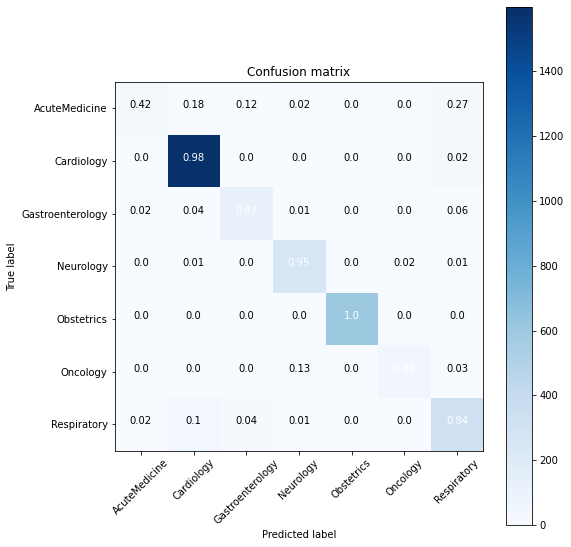

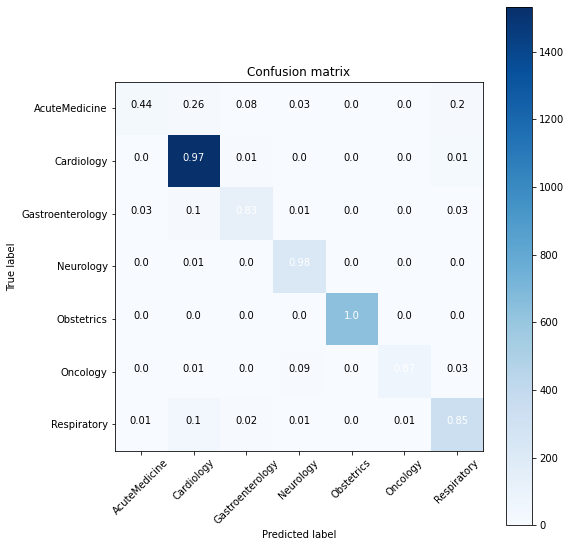

In [52]:
trained_model, dataset, class_labels = load_trained_prompt_model(ckpt_dir, params_dir)

In [64]:
trained_model.template.soft_token_ids

[0, 1, 0, 2, 3, 0, 0]

In [68]:
trained_model.template.tokenizer.decode(trained_model.template.soft_token_ids)

'[PAD] [unused1] [PAD] [unused2] [unused3] [PAD] [PAD]'

# BELOW TO BE REMOVED - WAS PLAYING AROUND

In [2]:
ckpt_dir = "./checkpoints/icd9_50/emilyalsentzer/Bio_ClinicalBERT_tempmanual2_verbsoft0/version_21-01-2022--13-41/checkpoint.ckpt"

In [21]:
loaded_model = torch.load(ckpt_dir)

In [18]:
loaded_model.keys()

dict_keys(['plm', 'template', 'verbalizer'])

In [14]:
PromptForClassification

TypeError: state_dict() missing 1 required positional argument: 'self'

In [ ]:
# the original way of instantiating a model

In [24]:
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "emilyalsentzer/Bio_ClinicalBERT")
# plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# can load the trained state dict for the plm like this

In [27]:
plm

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [28]:
# template

mytemplate = ManualTemplate(tokenizer=tokenizer).from_file("scripts/mimic_icd9_top50/manual_template.txt", choice=2)


In [41]:
# soft template

soft_template = SoftTemplate(model=plm, tokenizer=tokenizer, num_tokens=20, initialize_from_vocab=True).from_file(f"scripts/mimic_icd9_top50/soft_template.txt", choice=0)

In [42]:
soft_template

SoftTemplate(
  (raw_embedding): Embedding(28996, 768, padding_idx=0)
)

In [44]:
soft_template

OrderedDict([('[PAD]', 0),
             ('[unused1]', 1),
             ('[unused2]', 2),
             ('[unused3]', 3),
             ('[unused4]', 4),
             ('[unused5]', 5),
             ('[unused6]', 6),
             ('[unused7]', 7),
             ('[unused8]', 8),
             ('[unused9]', 9),
             ('[unused10]', 10),
             ('[unused11]', 11),
             ('[unused12]', 12),
             ('[unused13]', 13),
             ('[unused14]', 14),
             ('[unused15]', 15),
             ('[unused16]', 16),
             ('[unused17]', 17),
             ('[unused18]', 18),
             ('[unused19]', 19),
             ('[unused20]', 20),
             ('[unused21]', 21),
             ('[unused22]', 22),
             ('[unused23]', 23),
             ('[unused24]', 24),
             ('[unused25]', 25),
             ('[unused26]', 26),
             ('[unused27]', 27),
             ('[unused28]', 28),
             ('[unused29]', 29),
             ('[unused30]', 30),
 

In [29]:
# now try the verbalizer

soft_verb = SoftVerbalizer(tokenizer, plm, num_classes=50)

In [31]:
# now load the state dict from saved checkpoint
soft_verb.load_state_dict(loaded_model['verbalizer'])

<All keys matched successfully>

In [33]:
# now bring it all together into the prompt classification model

trained_model = PromptForClassification(plm=plm,template=mytemplate, verbalizer=soft_verb)

In [34]:
trained_model

PromptForClassification(
  (prompt_model): PromptModel(
    (plm): BertForMaskedLM(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(28996, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertSelfOutput(
          

In [47]:
model_config

BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_ClinicalBERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [97]:
def load_trained_prompt_model(ckpt_dir, plm_type,
                              plm_name, template_type,
                             template_id, verbalizer_type, verbalizer_id, scripts_path = "./scripts/",
                             init_from_vocab = True, data_dir = "../data/intermediary-data/",
                              dataset_name = "icd9_50", use_cuda = True):
    
    '''
    Function to reload an already trained promptmodelclassifier. At moment this still requires data/task specific 
    manual template or verbalizers to be setup as they need to point to correct scripts.
    
    Args:
        ckpt_dir: path to save promptmodel
        plm_type: the language model type e.g. bert, t5, gpt
        plm_name: the name of the pretrained model/checkpoint e.g. bert-base-uncased
        template_type: manual, mixed or soft prompt template?
        template_id: which row or idx of the file in scripts will the template be e.g. scripts/manual_template[0] is line 1
        verbalizer_type: this maps the tokens (mask prediction) to class labels. Can be one-to-one, many-to-one, 
                        and can be manual or soft
        verbalizer_id: which row or idx of the file in scripts will the verbalizer be e.g. scripts/manual_verbalizer[0] is line 1
        scriptnase: path to scripts directory    
        init_from_vocab: whether soft templates should be initialized from the plms vocabulary
        
    '''
    
    
    # set up datasets first
    
    dataset_name = dataset_name
    data_dir = data_dir
    batch_size = 4


    dataset = {}
    if dataset_name == "icd9_50":

        logger.warning(f"Using the following dataset: {dataset_name} ")
        Processor = Mimic_ICD9_Processor
        # update data_dir
        data_dir = f"{data_dir}/top_50_icd9"

        # get different splits
        dataset['train'] = Processor().get_examples(data_dir = data_dir, mode = "train")
        dataset['validation'] = Processor().get_examples(data_dir = data_dir, mode = "valid")
        dataset['test'] = Processor().get_examples(data_dir = data_dir, mode = "test")[:500]
        # the below class labels should align with the label encoder fitted to training data
        # you will need to generate this class label text file first using the mimic processor with generate_class_labels flag to set true
        # e.g. Processor().get_examples(data_dir = data_dir, mode = "train", generate_class_labels = True)[:10000]
        class_labels =Processor().load_class_labels()
        print(f"number of classes: {len(class_labels)}")
        scriptsbase = f"{scripts_path}/mimic_icd9_top50/"
        scriptformat = "txt"
        max_seq_l = 480 # this should be specified according to the running GPU's capacity 

        batchsize_t = batch_size
        batchsize_e = batch_size
        gradient_accumulation_steps = 4
        model_parallelize = False

    elif dataset_name == "icd9_triage":
        logger.warning(f"Using the following dataset: {dataset_name} ")
        Processor = Mimic_ICD9_Triage_Processor
        # update data_dir
        data_dir = f"{data_dir}/triage"

        # get different splits
        dataset['train'] = Processor().get_examples(data_dir = data_dir, mode = "train")
        dataset['validation'] = Processor().get_examples(data_dir = data_dir, mode = "valid")
        dataset['test'] = Processor().get_examples(data_dir = data_dir, mode = "test")[:500]
        # the below class labels should align with the label encoder fitted to training data
        # you will need to generate this class label text file first using the mimic processor with generate_class_labels flag to set true
        # e.g. Processor().get_examples(data_dir = data_dir, mode = "train", generate_class_labels = True)[:10000]
        class_labels =Processor().load_class_labels()
        print(f"number of classes: {len(class_labels)}")
        scriptsbase = f"{scripts_path}/mimic_triage/"
        scriptformat = "txt"
        max_seq_l = 480 # this should be specified according to the running GPU's capacity 

        batchsize_t = batch_size
        batchsize_e = batch_size
        gradient_accumulation_steps = 4
        model_parallelize = False
    else:
        #TODO implement icd9 triage and mimic readmission
        raise NotImplementedError
    
    
    ######### set up the pretrained model etc ###########
    
    # initialise the pretrained language model
    plm, tokenizer, model_config, WrapperClass = load_plm(plm_type, plm_name)
    
    # load the already trained prompt model, which will consist of a separate state_dict for the plm/template/verbalizer
    loaded_model = torch.load(ckpt_dir)
    
    
    # now load the trained state_dict into the plm model
    plm.load_state_dict(loaded_model['plm'])
    
    
    # decide which template and verbalizer to use
    if template_type == "manual":
        print(f"manual template selected, with id :{template_id}")
        mytemplate = ManualTemplate(tokenizer=tokenizer).from_file(f"{scriptsbase}/manual_template.txt", choice=template_id)

    elif template_type == "soft":
        print(f"soft template selected, with id :{template_id}")
        mytemplate = SoftTemplate(model=plm, tokenizer=tokenizer, num_tokens=soft_token_num, initialize_from_vocab=init_from_vocab).from_file(f"{scriptsbase}/soft_template.txt", choice=template_id)
        # now load the state_dict from ckpt
        mytemplate.load_state_dict(loaded_model['template'])

    elif template_type == "mixed":
        print(f"mixed template selected, with id :{template_id}")
        mytemplate = MixedTemplate(model=plm, tokenizer=tokenizer).from_file(f"{scriptsbase}/mixed_template.txt", choice=template_id)
        
    # now set verbalizer
    if verbalizer_type == "manual":
        print(f"manual verbalizer selected, with id :{verbalizer_id}")
        myverbalizer = ManualVerbalizer(tokenizer, classes=class_labels).from_file(f"{scriptsbase}/manual_verbalizer.{scriptformat}", choice=verbalizer_id)

    elif verbalizer_type == "soft":
        print(f"soft verbalizer selected!")
        myverbalizer = SoftVerbalizer(tokenizer, plm, num_classes=50)
        # now load the state dict from saved checkpoint
        myverbalizer.load_state_dict(loaded_model['verbalizer'])
        
    # now bring it all together into the prompt classification model

    trained_model = PromptForClassification(plm=plm,template=mytemplate, verbalizer=myverbalizer)
    
    # send to cuda
    if use_cuda:
        print("using cuda!")
        trained_model =  trained_model.cuda()
    
    # set up mimic data processors
    # Below are multiple dataset examples, although right now just mimic ic9-top50. 
    
    # set up test dataloader
    test_dataloader = PromptDataLoader(dataset=dataset["test"], template=mytemplate, tokenizer=tokenizer, 
        tokenizer_wrapper_class=WrapperClass, max_seq_length=max_seq_l, decoder_max_length=3, 
        batch_size=batchsize_e,shuffle=False, teacher_forcing=False, predict_eos_token=False,
        truncate_method="tail")
    
    # run evaluation
    acc, prec, recall, f1, cm, cm_figure = evaluate(trained_model,test_dataloader, class_labels, "test", use_cuda)
    
    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    
    cm_figure.show()
    

    
    return trained_model, dataset, class_labels
    
    
    
    
    


at moment this is a bit crude - as hparams have to be manually coded. And the hparams txt files are not easily usable at moment


2022-02-08 14:56:21.229 | WARNING  | __main__:load_trained_prompt_model:36 - Using the following dataset: icd9_50 


loading train data
data path provided was: ../data/intermediary-data//top_50_icd9/train.csv


14360it [00:01, 8765.46it/s]


loading valid data
data path provided was: ../data/intermediary-data//top_50_icd9/valid.csv


4693it [00:00, 8973.15it/s]


loading test data
data path provided was: ../data/intermediary-data//top_50_icd9/test.csv


4754it [00:00, 8876.72it/s]


number of classes: 50


Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


manual template selected, with id :2
soft verbalizer selected!
using cuda!


tokenizing: 500it [00:13, 36.52it/s]
evaluating: 125it [00:10, 12.23it/s]
/home/niallt/venvs/nlp_projects/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/niallt/venvs/nlp_projects/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/niallt/venvs/nlp_projects/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

accuracy using manual method: 0.692
[30, 39, 13, 48, 18, 26, 33, 21, 2, 24, 16, 38, 43, 13, 37, 6, 31, 48, 13, 4, 29, 13, 1, 25, 30, 22, 32, 23, 13, 13, 4, 22, 12, 44, 12, 13, 16, 13, 13, 48, 47, 13, 22, 32, 13, 27, 34, 22, 15, 30, 17, 48, 1, 13, 4, 5, 25, 10, 13, 4, 13, 4, 7, 16, 4, 21, 34, 19, 47, 17, 22, 40, 36, 1, 14, 31, 30, 13, 16, 4, 33, 13, 3, 47, 11, 13, 4, 13, 13, 47, 42, 13, 37, 12, 34, 13, 21, 6, 16, 12, 27, 4, 13, 24, 7, 46, 27, 47, 13, 13, 27, 10, 48, 22, 32, 4, 28, 32, 44, 2, 16, 16, 19, 13, 13, 12, 25, 11, 5, 10, 4, 46, 20, 47, 14, 21, 16, 12, 15, 13, 11, 44, 16, 47, 30, 4, 47, 32, 13, 9, 29, 16, 7, 2, 31, 12, 22, 46, 32, 14, 15, 38, 24, 2, 32, 12, 7, 18, 12, 37, 13, 40, 12, 48, 25, 24, 4, 12, 19, 35, 4, 4, 47, 47, 47, 15, 32, 23, 4, 47, 13, 10, 12, 41, 4, 19, 12, 40, 11, 36, 22, 20, 5, 47, 32, 13, 17, 13, 47, 18, 37, 4, 14, 21, 22, 35, 16, 4, 43, 33, 47, 13, 39, 35, 18, 45, 46, 13, 11, 11, 12, 19, 7, 32, 46, 13, 46, 30, 19, 29, 31, 28, 47, 31, 16, 48, 22, 13, 22, 47, 2

/home/niallt/venvs/nlp_projects/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


NameError: name 'itertools' is not defined

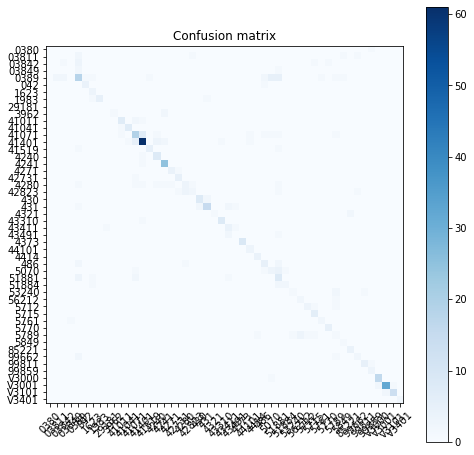

In [102]:
# need to refactor the entire training pipeline to store everything including template types etc in a reloadable way
# BEST PLAN IS TO SHIFT TO PYTORCH LIGHTNING FOR TRAINING

# set up params based on the saved ckpt name
ckpt_dir = "./checkpoints/icd9_50/emilyalsentzer/Bio_ClinicalBERT_tempmanual2_verbsoft0/version_21-01-2022--13-41/checkpoint.ckpt"
plm_type = "bert"
plm_name = "emilyalsentzer/Bio_ClinicalBERT"
# plm_name = "bert-base-cased"
template_type = "manual"
template_id = 2
verbalizer_type = "soft"
verbalizer_id = 0 
dataset_name = "icd9_50"



trained_prompt_model, dataset, class_labels = load_trained_prompt_model(ckpt_dir,plm_type,
                              plm_name, template_type,
                             template_id, verbalizer_type, verbalizer_id, scripts_path = "./scripts/",
                             init_from_vocab = True, data_dir = "../data/intermediary-data/",
                              dataset_name = "icd9_50")


In [69]:
len(class_labels)

50

In [16]:
trained_prompt_model.plm.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [45]:
class_labels

['0380',
 '03811',
 '03842',
 '03849',
 '0389',
 '042',
 '1623',
 '1983',
 '29181',
 '3962',
 '41011',
 '41041',
 '41071',
 '41401',
 '41519',
 '4240',
 '4241',
 '4271',
 '42731',
 '4280',
 '42823',
 '430',
 '431',
 '4321',
 '43310',
 '43411',
 '43491',
 '4373',
 '44101',
 '4414',
 '486',
 '5070',
 '51881',
 '51884',
 '53240',
 '56212',
 '5712',
 '5715',
 '5761',
 '5770',
 '5789',
 '5849',
 '85221',
 '99662',
 '99811',
 '99859',
 'V3000',
 'V3001',
 'V3101',
 'V3401']

NameError: name 'mytemplate' is not defined